In [3]:
# セルの最初に（他のインポートより前に）
import os
os.environ['LIBGL_DRIVERS_PATH'] = '/usr/lib/x86_64-linux-gnu/dri'
os.environ['LIBGL_ALWAYS_SOFTWARE'] = '1'

import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from neuromaps import stats
import glob
from util import plot
from util.atlas import Atlas
import matplotlib.pyplot as plt
from constants import SUBS

import seaborn as sns
from pathlib import Path
from neuromaps import stats


%matplotlib inline
plt.rcParams['figure.dpi'] = 60

def load_results(h5_path: str) -> dict:
    """HDF5ファイルから結果を読み込む"""
    results = {}
    with h5py.File(h5_path, "r") as f:
        for key in f.keys():
            results[key] = f[key][...]
    return results

def extract_scores(results: dict, narratives: list) -> dict:
    """各train->testペアのスコアを抽出"""
    scores_dict = {}
    for train_narr in narratives:
        for test_narr in narratives:
            # if train_narr == test_narr:
            #     continue
            key = f"{train_narr}->{test_narr}_scores"
            if key in results:
                scores_dict[(train_narr, test_narr)] = results[key]
    return scores_dict

/home/s-kawashima/miniconda3/envs/zaida_tutorial/lib/python3.12/site-packages/neuromaps/datasets/utils.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [4]:
whisper_tiny_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average/whisper-tiny_layer-3/sub-average.h5"
sa_whisper_tiny_path = "/home/s-kawashima/research/output/results/encoding_average_sentence-audio/sub-average/whisper-tiny_layer-3/sub-average.h5"
sbert_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average/all-MiniLM-L6-v2_cumulative_layer-6/sub-average.h5"
sbert_addone_path = "/home/s-kawashima/research/output/results/encoding_average/sub-average/all-MiniLM-L6-v2_cumulative_sentence_embedding_add_one-sentence/sub-average.h5"
multimodal_addone_path = "/home/s-kawashima/research/output/results/encoding_average_add_one-sentence/sub-average/combined_whisper-whisper-tiny_layer-3_sbert-all-MiniLM-L6-v2_layer--1/sub-average.h5"
whisper_tiny_results = load_results(whisper_tiny_path)
sa_whisper_tiny_results = load_results(sa_whisper_tiny_path)
sbert_results = load_results(sbert_path)
sbert_addone_results = load_results(sbert_addone_path)
multimodal_results = load_results(multimodal_addone_path)

In [6]:
atlas = Atlas.schaefer(parcels=1000, networks=7, kong=False)

TARGET_NETWORKS = ['DorsAttn', 'SalVentAttn', 'Default']
parcel_labels = atlas.labels

def get_network_mask(labels, target_networks):
    mask = np.zeros(len(labels), dtype=bool)
    for i, label in enumerate(labels):
        for network in target_networks:
            if f'_{network}_' in label:
                mask[i] = True
                break
    return mask

network_mask = get_network_mask(parcel_labels, TARGET_NETWORKS)

# ネットワーク定義と色
TARGET_NETWORKS_INFO = {
    # 'SomMot': {'color': '#1f77b4', 'id': 1},      # 青
    'DorsAttn': {'color': '#2ca02c', 'id': 2},    # 緑
    'SalVentAttn': {'color': '#9467bd', 'id': 3}, # 紫
    'Default': {'color': '#d62728', 'id': 4}      # 赤
}

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

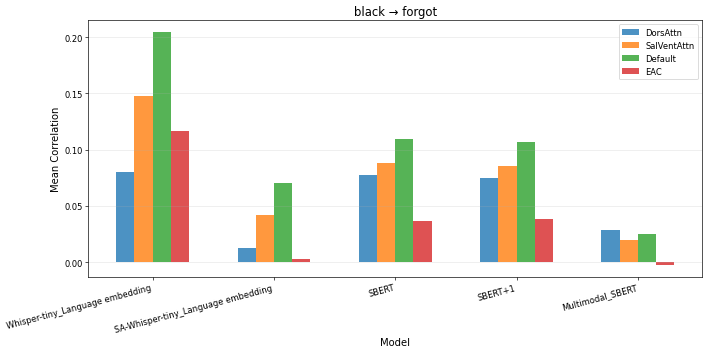


black → forgot
--------------------------------------------------------------------------------
Region          | Whisper-tiny_Language embedding | SA-Whisper-tiny_Language embedding | SBERT           | SBERT+1         | Multimodal_SBERT
--------------------------------------------------------------------------------
DorsAttn        |          0.0801 |          0.0126 |          0.0775 |          0.0748 |          0.0284
SalVentAttn     |          0.1478 |          0.0417 |          0.0884 |          0.0850 |          0.0192
Default         |          0.2049 |          0.0700 |          0.1092 |          0.1067 |          0.0246
EAC             |          0.1163 |          0.0023 |          0.0368 |          0.0380 |         -0.0029


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

# 設定
TRAIN_STORY = "black"
TEST_STORY = "forgot"
FEATURE_IDX = 3
FEATURE_NAME = "SBERT"

# ディレクトリ設定
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

# EACマスク読み込み
from neuromaps import images
eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_data = np.concatenate((eac_lh_data, eac_rh_data))
eac_mask_vertex = eac_data > 0

# Yeoネットワーク定義
TARGET_NETWORKS = ['DorsAttn', 'SalVentAttn', 'Default']

# データ抽出関数
def extract_network_values(results, train_story, test_story, feature_idx, atlas, network_name):
    """指定されたネットワークの値を抽出"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # ネットワークマスク作成
    parcel_labels = atlas.labels
    network_parcel_mask = np.array([1.0 if f'_{network_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex_mask = atlas.parc_to_vox(network_parcel_mask) > 0
    
    # マスク適用して平均値を計算
    network_values = vertex_data[network_vertex_mask]
    return np.nanmean(network_values)

def extract_eac_values(results, train_story, test_story, feature_idx, atlas, eac_mask_vertex):
    """EAC領域の値を抽出"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # EACマスク適用して平均値を計算
    eac_values = vertex_data[eac_mask_vertex]
    return np.nanmean(eac_values)

# モデルとそのfeature_idxの設定
models_config = {
    'Whisper Language model': (whisper_tiny_results, 2),
    'Whisper Language model\n(Sentence Segmented)': (sa_whisper_tiny_results, 2),
    'SBERT model': (sbert_results, 0),
    'SBERT model+1': (sbert_addone_results, 0),
    'Multimodal\nLanguage model': (multimodal_results, 2),
    'Multimodal\nSBERT model': (multimodal_results, 3)
}

# データ収集
regions = TARGET_NETWORKS + ['EAC']
all_model_means = {model_name: [] for model_name in models_config.keys()}

# 各モデルについてデータを抽出
for model_name, (results, feature_idx) in models_config.items():
    # Yeoネットワークの値を抽出
    for network in TARGET_NETWORKS:
        mean_val = extract_network_values(results, TRAIN_STORY, TEST_STORY, 
                                         feature_idx, atlas, network)
        all_model_means[model_name].append(mean_val)
    
    # EACの値を抽出
    eac_val = extract_eac_values(results, TRAIN_STORY, TEST_STORY, 
                                 feature_idx, atlas, eac_mask_vertex)
    all_model_means[model_name].append(eac_val)

# 棒グラフ作成（横軸をモデルに変更）
fig, ax = plt.subplots(figsize=(12, 6))

models = list(models_config.keys())
x = np.arange(len(models))
width = 0.15  # 5つの領域を並べるため幅を狭く

# 各領域ごとに棒を作成
for i, region in enumerate(regions):
    values = [all_model_means[model][i] for model in models]
    offset = width * (i - len(regions)/2 + 0.5)
    ax.bar(x + offset, values, width, label=region, alpha=0.8)

# ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Mean Correlation', fontsize=24)
# ax.set_title(f'{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right', fontsize=16)
ax.y
# ax.legend(loc='upper right')
# ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig(f'./surface_plot/comparison_{TRAIN_STORY}_to_{TEST_STORY}_all_models.png', 
#             dpi=300, bbox_inches='tight')
plt.show()

# 数値も表示
print(f"\n{TRAIN_STORY} → {TEST_STORY}")
print("-" * 80)
print(f"{'Region':15s} | " + " | ".join([f"{m:15s}" for m in models]))
print("-" * 80)
for i, region in enumerate(regions):
    values_str = " | ".join([f"{all_model_means[model][i]:15.4f}" for model in models])
    print(f"{region:15s} | {values_str}")

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

# 設定
TRAIN_STORY = "black"
TEST_STORY = "forgot"
FEATURE_IDX = 3
FEATURE_NAME = "SBERT"

# ディレクトリ設定
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

# EACマスク読み込み
from neuromaps import images
eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_data = np.concatenate((eac_lh_data, eac_rh_data))
eac_mask_vertex = eac_data > 0

# Yeoネットワーク定義と色設定（落ち着いたトーン）
TARGET_NETWORKS_INFO = {
    'DorsAttn': {'color': '#32CD32'},    # ライムグリーン（やや暗め）
    'SalVentAttn': {'color': '#DA70D6'}, # オーキッド（落ち着いたマゼンタ）
    'Default': {'color': '#FF6347'}      # トマト（やや落ち着いたオレンジレッド）
}

# EAC設定
EAC_COLOR = '#4682B4'

TARGET_NETWORKS = list(TARGET_NETWORKS_INFO.keys())

# データ抽出関数
def extract_network_values(results, train_story, test_story, feature_idx, atlas, network_name):
    """指定されたネットワークの値を抽出"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # ネットワークマスク作成
    parcel_labels = atlas.labels
    network_parcel_mask = np.array([1.0 if f'_{network_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex_mask = atlas.parc_to_vox(network_parcel_mask) > 0
    
    # マスク適用して平均値を計算
    network_values = vertex_data[network_vertex_mask]
    return np.nanmean(network_values)

def extract_eac_values(results, train_story, test_story, feature_idx, atlas, eac_mask_vertex):
    """EAC領域の値を抽出"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # EACマスク適用して平均値を計算
    eac_values = vertex_data[eac_mask_vertex]
    return np.nanmean(eac_values)

# モデルとそのfeature_idxの設定
models_config = {
    'Whisper Language model': (whisper_tiny_results, 2),
    'Whisper Language model\n(Sentence Segmented)': (sa_whisper_tiny_results, 2),
    'SBERT model': (sbert_results, 0),
    'SBERT model+1': (sbert_addone_results, 0),
    'Multimodal\nLanguage model': (multimodal_results, 2),
    'Multimodal\nSBERT model': (multimodal_results, 3)
}

# データ収集
regions = TARGET_NETWORKS + ['EAC']
region_colors = [TARGET_NETWORKS_INFO[net]['color'] for net in TARGET_NETWORKS] + [EAC_COLOR]
all_model_means = {model_name: [] for model_name in models_config.keys()}

# 各モデルについてデータを抽出
for model_name, (results, feature_idx) in models_config.items():
    # Yeoネットワークの値を抽出
    for network in TARGET_NETWORKS:
        mean_val = extract_network_values(results, TRAIN_STORY, TEST_STORY, 
                                         feature_idx, atlas, network)
        all_model_means[model_name].append(mean_val)
    
    # EACの値を抽出
    eac_val = extract_eac_values(results, TRAIN_STORY, TEST_STORY, 
                                 feature_idx, atlas, eac_mask_vertex)
    all_model_means[model_name].append(eac_val)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join


# 設定
TRAIN_STORY = "black"
TEST_STORY = "black"
FEATURE_IDX = 2
FEATURE_NAME = "Language"
THRESHOLD = 0.2  # しきい値

# ディレクトリ設定
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

# EACマスク読み込み
from neuromaps import images
eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_data = np.concatenate((eac_lh_data, eac_rh_data))
eac_mask_vertex = eac_data > 0

# Yeoネットワーク定義と色設定（落ち着いたトーン）
TARGET_NETWORKS_INFO = {
    'DorsAttn': {'color': '#32CD32'},    # ライムグリーン（やや暗め）
    'SalVentAttn': {'color': '#DA70D6'}, # オーキッド（落ち着いたマゼンタ）
    'Default': {'color': '#FF6347'}      # トマト（やや落ち着いたオレンジレッド）
}

# EAC設定
EAC_COLOR = '#4682B4'

TARGET_NETWORKS = list(TARGET_NETWORKS_INFO.keys())

# データ抽出関数
def extract_network_values(results, train_story, test_story, feature_idx, atlas, network_name):
    """指定されたネットワークの値を抽出"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # ネットワークマスク作成
    parcel_labels = atlas.labels
    network_parcel_mask = np.array([1.0 if f'_{network_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex_mask = atlas.parc_to_vox(network_parcel_mask) > 0
    
    # マスク適用して平均値を計算
    network_values = vertex_data[network_vertex_mask]
    return np.nanmean(network_values)

def extract_eac_values(results, train_story, test_story, feature_idx, atlas, eac_mask_vertex):
    """EAC領域の値を抽出"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # EACマスク適用して平均値を計算
    eac_values = vertex_data[eac_mask_vertex]
    return np.nanmean(eac_values)

def count_parcels_above_threshold(results, train_story, test_story, feature_idx, 
                                   atlas, network_name, threshold=0.2):
    """指定されたネットワークでthreshold以上のパーセル数をカウント"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    
    # ネットワークマスク作成
    parcel_labels = atlas.labels
    network_parcel_mask = np.array([True if f'_{network_name}_' in label else False 
                                     for label in parcel_labels])
    
    # ネットワーク内のパーセル値を取得
    network_values = values[network_parcel_mask]
    
    # threshold以上のパーセル数をカウント
    above_threshold = np.sum(network_values >= threshold)
    total_parcels = len(network_values)
    percentage = (above_threshold / total_parcels * 100) if total_parcels > 0 else 0
    
    return above_threshold, total_parcels, percentage

def count_eac_parcels_above_threshold(results, train_story, test_story, feature_idx, 
                                       atlas, eac_mask_vertex, threshold=0.2):
    """EAC領域でthreshold以上のパーセル数をカウント（頂点ベース）"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # EACマスク適用
    eac_values = vertex_data[eac_mask_vertex]
    
    # threshold以上の頂点数をカウント
    above_threshold = np.sum(eac_values >= threshold)
    total_vertices = len(eac_values)
    percentage = (above_threshold / total_vertices * 100) if total_vertices > 0 else 0
    
    return above_threshold, total_vertices, percentage

# モデルとそのfeature_idxの設定
models_config = {
    'Whisper Language model': (whisper_tiny_results, 2),
    'Whisper Language model\n(Sentence Segmented)': (sa_whisper_tiny_results, 2),
    'SBERT model': (sbert_results, 0),
    'SBERT model+1': (sbert_addone_results, 0),
    'Multimodal\nLanguage model': (multimodal_results, 2),
    'Multimodal\nSBERT model': (multimodal_results, 3)
}

# データ収集
regions = TARGET_NETWORKS + ['EAC']
region_colors = [TARGET_NETWORKS_INFO[net]['color'] for net in TARGET_NETWORKS] + [EAC_COLOR]
all_model_means = {model_name: [] for model_name in models_config.keys()}

# 各モデルについてデータを抽出とパーセルカウント
print(f"\n{'='*80}")
print(f"Parcels with score >= {THRESHOLD} (Train: {TRAIN_STORY}, Test: {TEST_STORY})")
print(f"{'='*80}\n")

for model_name, (results, feature_idx) in models_config.items():
    print(f"\n{model_name}:")
    print("-" * 60)
    
    # Yeoネットワークの値を抽出とカウント
    for network in TARGET_NETWORKS:
        mean_val = extract_network_values(results, TRAIN_STORY, TEST_STORY, 
                                         feature_idx, atlas, network)
        all_model_means[model_name].append(mean_val)
        
        # パーセルカウント
        above_th, total, pct = count_parcels_above_threshold(
            results, TRAIN_STORY, TEST_STORY, feature_idx, atlas, network, THRESHOLD
        )
        print(f"  {network:15s}: {above_th:4d}/{total:4d} parcels ({pct:5.1f}%) | Mean: {mean_val:.4f}")
    
    # EACの値を抽出とカウント
    eac_val = extract_eac_values(results, TRAIN_STORY, TEST_STORY, 
                                 feature_idx, atlas, eac_mask_vertex)
    all_model_means[model_name].append(eac_val)
    
    # EACのカウント（頂点ベース）
    above_th, total, pct = count_eac_parcels_above_threshold(
        results, TRAIN_STORY, TEST_STORY, feature_idx, atlas, eac_mask_vertex, THRESHOLD
    )
    print(f"  {'EAC':15s}: {above_th:4d}/{total:4d} vertices ({pct:5.1f}%) | Mean: {eac_val:.4f}")

print(f"\n{'='*80}\n")


Parcels with score >= 0.2 (Train: black, Test: black)


Whisper Language model:
------------------------------------------------------------
  DorsAttn       :   81/ 122 parcels ( 66.4%) | Mean: 0.3425
  SalVentAttn    :   98/ 121 parcels ( 81.0%) | Mean: 0.4915
  Default        :  197/ 212 parcels ( 92.9%) | Mean: 0.6448
  EAC            : 1005/1446 vertices ( 69.5%) | Mean: 0.2426

Whisper Language model
(Sentence Segmented):
------------------------------------------------------------
  DorsAttn       :   51/ 122 parcels ( 41.8%) | Mean: 0.2082
  SalVentAttn    :   50/ 121 parcels ( 41.3%) | Mean: 0.2294
  Default        :  117/ 212 parcels ( 55.2%) | Mean: 0.3310
  EAC            :   32/1446 vertices (  2.2%) | Mean: 0.0161

SBERT model:
------------------------------------------------------------
  DorsAttn       :  122/ 122 parcels (100.0%) | Mean: 0.6467
  SalVentAttn    :  121/ 121 parcels (100.0%) | Mean: 0.6448
  Default        :  212/ 212 parcels (100.0%) | Mean: 0.7557
  E

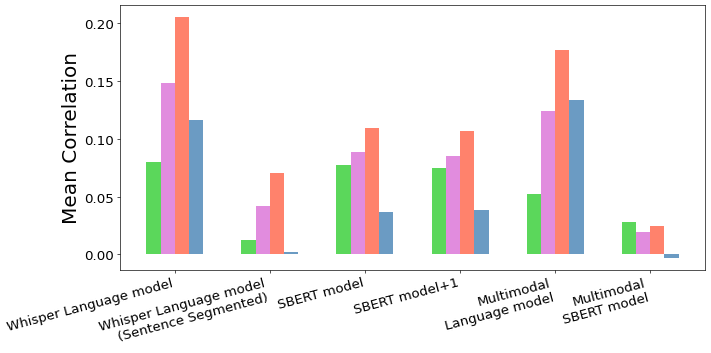


black → forgot
--------------------------------------------------------------------------------
Region          | Whisper Language model | Whisper Language model
(Sentence Segmented) | SBERT model     | SBERT model+1   | Multimodal
Language model | Multimodal
SBERT model
--------------------------------------------------------------------------------
DorsAttn        |          0.0801 |          0.0126 |          0.0775 |          0.0748 |          0.0520 |          0.0284
SalVentAttn     |          0.1478 |          0.0417 |          0.0884 |          0.0850 |          0.1236 |          0.0192
Default         |          0.2049 |          0.0700 |          0.1092 |          0.1067 |          0.1767 |          0.0246
EAC             |          0.1163 |          0.0023 |          0.0368 |          0.0380 |          0.1336 |         -0.0029


In [107]:
# 棒グラフ作成（横軸をモデルに変更）
fig, ax = plt.subplots(figsize=(12, 6))

models = list(models_config.keys())
x = np.arange(len(models))
width = 0.15  # 5つの領域を並べるため幅を狭く

# 各領域ごとに棒を作成（色を適用）
for i, region in enumerate(regions):
    values = [all_model_means[model][i] for model in models]
    offset = width * (i - len(regions)/2 + 0.5)
    ax.bar(x + offset, values, width, label=region, alpha=0.8, color=region_colors[i])

# ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Mean Correlation', fontsize=24)
# ax.set_title(f'{TRAIN_STORY} → {TEST_STORY}', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right', fontsize=16)

ax.tick_params(axis='y', labelsize=16)  # y軸のラベルサイズを大きく

# ax.legend(loc='upper right')
# ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'./figures/comparison_{TRAIN_STORY}_to_{TEST_STORY}_all_models.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 数値も表示
print(f"\n{TRAIN_STORY} → {TEST_STORY}")
print("-" * 80)
print(f"{'Region':15s} | " + " | ".join([f"{m:15s}" for m in models]))
print("-" * 80)
for i, region in enumerate(regions):
    values_str = " | ".join([f"{all_model_means[model][i]:15.4f}" for model in models])
    print(f"{region:15s} | {values_str}")

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

# 設定
TRAIN_STORY = "black"
TEST_STORIES = ["forgot", "piemanpni", "bronx"]  # 複数のテストストーリー
FEATURE_IDX = 3
FEATURE_NAME = "SBERT"

# ディレクトリ設定
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

# EACマスク読み込み
from neuromaps import images
eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_data = np.concatenate((eac_lh_data, eac_rh_data))
eac_mask_vertex = eac_data > 0

# Yeoネットワーク定義と色設定（落ち着いたトーン）
TARGET_NETWORKS_INFO = {
    'DorsAttn': {'color': '#32CD32'},    # ライムグリーン（やや暗め）
    'SalVentAttn': {'color': '#DA70D6'}, # オーキッド（落ち着いたマゼンタ）
    'Default': {'color': '#FF6347'}      # トマト（やや落ち着いたオレンジレッド）
}

# EAC設定
EAC_COLOR = '#4682B4'

TARGET_NETWORKS = list(TARGET_NETWORKS_INFO.keys())

# データ抽出関数
def extract_network_values(results, train_story, test_story, feature_idx, atlas, network_name):
    """指定されたネットワークの値を抽出"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # ネットワークマスク作成
    parcel_labels = atlas.labels
    network_parcel_mask = np.array([1.0 if f'_{network_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex_mask = atlas.parc_to_vox(network_parcel_mask) > 0
    
    # マスク適用して平均値を計算
    network_values = vertex_data[network_vertex_mask]
    return np.nanmean(network_values)

def extract_eac_values(results, train_story, test_story, feature_idx, atlas, eac_mask_vertex):
    """EAC領域の値を抽出"""
    values = results[f'{train_story}->{test_story}_scores'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(values)
    
    # EACマスク適用して平均値を計算
    eac_values = vertex_data[eac_mask_vertex]
    return np.nanmean(eac_values)

# モデルとそのfeature_idxの設定
models_config = {
    'Whisper Language model': (whisper_tiny_results, 2),
    'Whisper Language model\n(Sentence Segmented)': (sa_whisper_tiny_results, 2),
    'SBERT model': (sbert_results, 0),
    'SBERT model+1': (sbert_addone_results, 0),
    'Multimodal\nLanguage model': (multimodal_results, 2),
    'Multimodal\nSBERT model': (multimodal_results, 3)
}

# データ収集
regions = TARGET_NETWORKS + ['EAC']
region_colors = [TARGET_NETWORKS_INFO[net]['color'] for net in TARGET_NETWORKS] + [EAC_COLOR]


In [10]:

# 各モデルについて、3つのテストストーリーの平均を計算
all_model_means = {model_name: [] for model_name in models_config.keys()}

for model_name, (results, feature_idx) in models_config.items():
    # 各領域について3つのテストストーリーの平均を計算
    for i, region in enumerate(regions):
        story_values = []
        
        for test_story in TEST_STORIES:
            if region == 'EAC':
                # EACの値を抽出
                val = extract_eac_values(results, TRAIN_STORY, test_story, 
                                        feature_idx, atlas, eac_mask_vertex)
            else:
                # Yeoネットワークの値を抽出
                val = extract_network_values(results, TRAIN_STORY, test_story, 
                                            feature_idx, atlas, region)
            story_values.append(val)
        
        # 3つのストーリーの平均を計算
        mean_val = np.nanmean(story_values)
        all_model_means[model_name].append(mean_val)

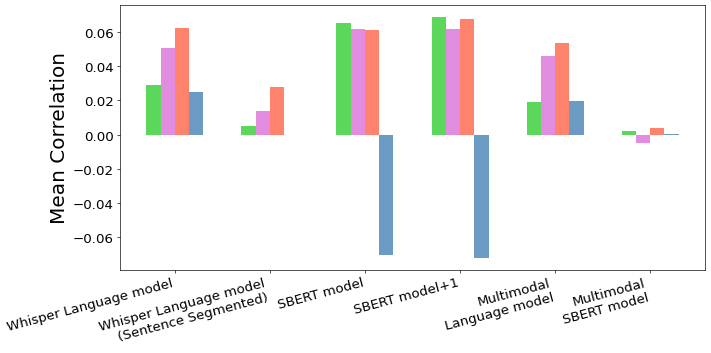


black → Average of ['forgot', 'piemanpni', 'bronx']
--------------------------------------------------------------------------------
Region          | Whisper Language model | Whisper Language model
(Sentence Segmented) | SBERT model     | SBERT model+1   | Multimodal
Language model | Multimodal
SBERT model
--------------------------------------------------------------------------------
DorsAttn        |          0.0289 |          0.0048 |          0.0653 |          0.0689 |          0.0192 |          0.0022
SalVentAttn     |          0.0509 |          0.0141 |          0.0618 |          0.0620 |          0.0462 |         -0.0047
Default         |          0.0626 |          0.0280 |          0.0612 |          0.0677 |          0.0538 |          0.0038
EAC             |          0.0251 |         -0.0001 |         -0.0706 |         -0.0722 |          0.0198 |          0.0005


In [11]:
# 棒グラフ作成（横軸をモデルに変更）
fig, ax = plt.subplots(figsize=(12, 6))

models = list(models_config.keys())
x = np.arange(len(models))
width = 0.15  # 5つの領域を並べるため幅を狭く

# 各領域ごとに棒を作成（色を適用）
for i, region in enumerate(regions):
    values = [all_model_means[model][i] for model in models]
    offset = width * (i - len(regions)/2 + 0.5)
    ax.bar(x + offset, values, width, label=region, alpha=0.8, color=region_colors[i])

# ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Mean Correlation', fontsize=24)
# ax.set_title(f'{TRAIN_STORY} → Average of ({", ".join(TEST_STORIES)})', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right', fontsize=16)
# ax.legend(loc='upper right')
# ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='y', labelsize=16)  # y軸のラベルサイズを大きく


plt.tight_layout()
plt.savefig(f'./figures/comparison_{TRAIN_STORY}_to_average_all_models.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# 数値も表示
print(f"\n{TRAIN_STORY} → Average of {TEST_STORIES}")
print("-" * 80)
print(f"{'Region':15s} | " + " | ".join([f"{m:15s}" for m in models]))
print("-" * 80)
for i, region in enumerate(regions):
    values_str = " | ".join([f"{all_model_means[model][i]:15.4f}" for model in models])
    print(f"{region:15s} | {values_str}")


Pearson Correlation between Actual and Predicted (Train: black)


Whisper-tiny_Language embedding:
------------------------------------------------------------------------------------------------------------------------
  DorsAttn        | forgot      : r =  0.1261, p = 0.0000e+00 *** (n = 4838418)
  DorsAttn        | piemanpni   : r = -0.0176, p = 8.4100e-159 *** (n = 2315157)
  DorsAttn        | bronx       : r = -0.0010, p = 6.9544e-02     (n = 3104218)
  DorsAttn        | MEAN        : r =  0.0358
  EAC             | forgot      : r =  0.3431, p = 0.0000e+00 *** (n = 806868)
  EAC             | piemanpni   : r = -0.0269, p = 1.1148e-62 *** (n = 386082)
  EAC             | bronx       : r = -0.0445, p = 8.4341e-225 *** (n = 517668)
  EAC             | MEAN        : r =  0.0906

SBERT:
------------------------------------------------------------------------------------------------------------------------
  DorsAttn        | forgot      : r =  0.0536, p = 0.0000e+00 *** (n = 4838418)

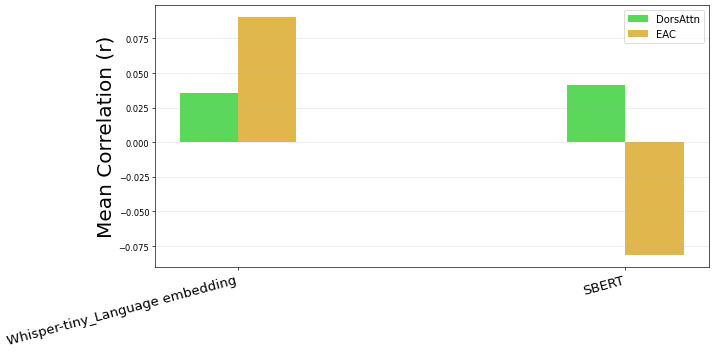


Mean Correlation across test stories (black → forgot, piemanpni, bronx)
----------------------------------------------------------------------------------------------------
Region          | Whisper-tiny_Language embedding | SBERT               
----------------------------------------------------------------------------------------------------
DorsAttn        |               0.0358 |               0.0417
EAC             |               0.0906 |              -0.0817

Individual Parcel Scores: DorsAttn network - SBERT model (black → forgot)

Rank   Parcel Index    Score      Label                                                       
------------------------------------------------------------------------------------------------------------------------
1      187             0.2583     7Networks_LH_DorsAttn_Post_16                               
2      743             0.1922     7Networks_RH_DorsAttn_PrCv_2                                
3      177             0.1872     7Networks_LH

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# 設定
TRAIN_STORY = "black"
TEST_STORIES = ["forgot", "piemanpni", "bronx"]  # 複数のテストストーリー
FEATURE_IDX = 3
FEATURE_NAME = "SBERT"

# ディレクトリ設定
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

# EACマスク読み込み
from neuromaps import images
eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_data = np.concatenate((eac_lh_data, eac_rh_data))
eac_mask_vertex = eac_data > 0

# Yeoネットワーク定義と色設定（落ち着いたトーン）
TARGET_NETWORKS_INFO = {
    # 'SomMot': {'color': '#4682B4'},      # スチールブルー
    'DorsAttn': {'color': '#32CD32'},    # ライムグリーン（やや暗め）
    # 'SalVentAttn': {'color': '#DA70D6'}, # オーキッド（落ち着いたマゼンタ）
    # 'Default': {'color': '#FF6347'}      # トマト（やや落ち着いたオレンジレッド）
}

# EAC設定
EAC_COLOR = '#DAA520'  # ゴールデンロッド（落ち着いた黄色）

TARGET_NETWORKS = list(TARGET_NETWORKS_INFO.keys())

# データ抽出関数（pearsonrを使用）
def extract_network_correlation(results, train_story, test_story, feature_idx, atlas, network_name):
    """指定されたネットワークのactualとpredを抽出してpearsonrで相関を計算"""
    # actualとpredを取得 (shape: (n_timepoints, n_parcels))
    actual = results[f'{train_story}->{test_story}_actual']  # (558, 1000)
    pred = results[f'{train_story}->{test_story}_preds'][feature_idx]  # (558, 1000)
    
    # 全パーセルを頂点に変換（時間点ごとに処理）
    n_timepoints = actual.shape[0]
    actual_vertex_list = []
    pred_vertex_list = []
    
    for t in range(n_timepoints):
        actual_vertex_list.append(atlas.parc_to_vox(actual[t, :]))
        pred_vertex_list.append(atlas.parc_to_vox(pred[t, :]))
    
    actual_vertex = np.array(actual_vertex_list)  # (558, n_vertices)
    pred_vertex = np.array(pred_vertex_list)  # (558, n_vertices)
    
    # ネットワークマスク（頂点レベル）を作成
    parcel_labels = atlas.labels
    network_parcel_mask_float = np.array([1.0 if f'_{network_name}_' in label else 0.0 
                                          for label in parcel_labels])
    network_vertex_mask = atlas.parc_to_vox(network_parcel_mask_float) > 0
    
    # ネットワーク内の頂点のみ抽出
    actual_network = actual_vertex[:, network_vertex_mask]  # (558, n_network_vertices)
    pred_network = pred_vertex[:, network_vertex_mask]  # (558, n_network_vertices)
    
    # 平坦化して1次元配列に
    actual_flat = actual_network.flatten()
    pred_flat = pred_network.flatten()
    
    # NaNを除外
    valid_mask = ~(np.isnan(actual_flat) | np.isnan(pred_flat))
    actual_valid = actual_flat[valid_mask]
    pred_valid = pred_flat[valid_mask]
    
    # Pearson相関を計算
    if len(actual_valid) > 1:
        corr, p_value = pearsonr(actual_valid, pred_valid)
        return corr, p_value, len(actual_valid)
    else:
        return np.nan, np.nan, 0

def extract_eac_correlation(results, train_story, test_story, feature_idx, atlas, eac_mask_vertex):
    """EAC領域のactualとpredを抽出してpearsonrで相関を計算"""
    # actualとpredを取得 (shape: (n_timepoints, n_parcels))
    actual = results[f'{train_story}->{test_story}_actual']  # (558, 1000)
    pred = results[f'{train_story}->{test_story}_preds'][feature_idx]  # (558, 1000)
    
    # 全パーセルを頂点に変換（時間点ごとに処理）
    n_timepoints = actual.shape[0]
    actual_vertex_list = []
    pred_vertex_list = []
    
    for t in range(n_timepoints):
        actual_vertex_list.append(atlas.parc_to_vox(actual[t, :]))
        pred_vertex_list.append(atlas.parc_to_vox(pred[t, :]))
    
    actual_vertex = np.array(actual_vertex_list)  # (558, n_vertices)
    pred_vertex = np.array(pred_vertex_list)  # (558, n_vertices)
    
    # EACマスク適用
    actual_eac = actual_vertex[:, eac_mask_vertex]  # (558, n_eac_vertices)
    pred_eac = pred_vertex[:, eac_mask_vertex]  # (558, n_eac_vertices)
    
    # 平坦化して1次元配列に
    actual_flat = actual_eac.flatten()
    pred_flat = pred_eac.flatten()
    
    # NaNを除外
    valid_mask = ~(np.isnan(actual_flat) | np.isnan(pred_flat))
    actual_valid = actual_flat[valid_mask]
    pred_valid = pred_flat[valid_mask]
    
    # Pearson相関を計算
    if len(actual_valid) > 1:
        corr, p_value = pearsonr(actual_valid, pred_valid)
        return corr, p_value, len(actual_valid)
    else:
        return np.nan, np.nan, 0

def get_parcel_scores(results, train_story, test_story, feature_idx, atlas, network_name):
    """指定されたネットワークの各パーセルごとのスコアを取得"""
    # スコアを取得（パーセルレベル）
    scores = results[f'{train_story}->{test_story}_scores'][feature_idx]
    
    # ネットワークマスクとラベルを取得
    parcel_labels = atlas.labels
    network_parcel_indices = [i for i, label in enumerate(parcel_labels) if f'_{network_name}_' in label]
    
    parcel_results = []
    for idx in network_parcel_indices:
        score_val = scores[idx]
        
        if not np.isnan(score_val):
            parcel_results.append({
                'index': idx,
                'label': parcel_labels[idx],
                'score': score_val
            })
    
    return parcel_results

# モデルとそのfeature_idxの設定
models_config = {
    'Whisper-tiny_Language embedding': (whisper_tiny_results, 2),
    # 'SA-Whisper-tiny_Language embedding': (sa_whisper_tiny_results, 2),
    'SBERT': (sbert_results, 0),
    # 'SBERT+1': (sbert_addone_results, 0),
    # 'Multimodal_SBERT': (multimodal_results, 3),
    # 'Multimodal_Language embedding': (multimodal_results, 2)
}

# データ収集
regions = TARGET_NETWORKS + ['EAC']
region_colors = [TARGET_NETWORKS_INFO[net]['color'] for net in TARGET_NETWORKS] + [EAC_COLOR]

# 相関結果を保存
print(f"\n{'='*120}")
print(f"Pearson Correlation between Actual and Predicted (Train: {TRAIN_STORY})")
print(f"{'='*120}\n")

# 各モデルについて、3つのテストストーリーの平均を計算
all_model_means = {model_name: [] for model_name in models_config.keys()}
all_pvalues = []  # FDR補正用にすべてのp値を収集

for model_name, (results, feature_idx) in models_config.items():
    print(f"\n{model_name}:")
    print("-" * 120)
    
    # 各領域について3つのテストストーリーの平均を計算
    for i, region in enumerate(regions):
        story_corrs = []
        story_pvals = []
        
        for test_story in TEST_STORIES:
            if region == 'EAC':
                # EACの相関を計算
                corr, p_val, n = extract_eac_correlation(results, TRAIN_STORY, test_story, 
                                                         feature_idx, atlas, eac_mask_vertex)
            else:
                # Yeoネットワークの相関を計算
                corr, p_val, n = extract_network_correlation(results, TRAIN_STORY, test_story, 
                                                             feature_idx, atlas, region)
            
            story_corrs.append(corr)
            story_pvals.append(p_val)
            all_pvalues.append(p_val)
            
            # 個別のテストストーリーの結果を表示（FDR補正前）
            sig_mark = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            print(f"  {region:15s} | {test_story:12s}: r = {corr:7.4f}, p = {p_val:.4e} {sig_mark:3s} (n = {n:5d})")
        
        # 3つのストーリーの平均相関を計算
        mean_corr = np.nanmean(story_corrs)
        all_model_means[model_name].append(mean_corr)
        
        print(f"  {region:15s} | {'MEAN':12s}: r = {mean_corr:7.4f}")

print(f"\n{'='*120}\n")

# FDR補正を実施
print(f"\n{'='*120}")
print(f"FDR-Corrected P-values (Benjamini-Hochberg method)")
print(f"{'='*120}\n")

# NaNを除外してFDR補正
valid_pvals = [p for p in all_pvalues if not np.isnan(p)]
if len(valid_pvals) > 0:
    rejected, pvals_corrected, _, _ = multipletests(valid_pvals, alpha=0.05, method='fdr_bh')
    
    # 元のインデックスに戻す
    pvals_corrected_full = []
    corrected_idx = 0
    for p in all_pvalues:
        if not np.isnan(p):
            pvals_corrected_full.append(pvals_corrected[corrected_idx])
            corrected_idx += 1
        else:
            pvals_corrected_full.append(np.nan)
    
    # FDR補正後の結果を表示
    idx = 0
    for model_name, (results, feature_idx) in models_config.items():
        print(f"\n{model_name}:")
        print("-" * 120)
        
        for i, region in enumerate(regions):
            for test_story in TEST_STORIES:
                p_val_corrected = pvals_corrected_full[idx]
                
                # 元のp値を再計算（表示用）
                if region == 'EAC':
                    corr, p_val, n = extract_eac_correlation(results, TRAIN_STORY, test_story, 
                                                             feature_idx, atlas, eac_mask_vertex)
                else:
                    corr, p_val, n = extract_network_correlation(results, TRAIN_STORY, test_story, 
                                                                 feature_idx, atlas, region)
                
                # FDR補正後の有意性マーク
                sig_mark_fdr = '***' if p_val_corrected < 0.001 else '**' if p_val_corrected < 0.01 else '*' if p_val_corrected < 0.05 else ''
                
                print(f"  {region:15s} | {test_story:12s}: r = {corr:7.4f}, p_raw = {p_val:.4e}, p_fdr = {p_val_corrected:.4e} {sig_mark_fdr:3s}")
                
                idx += 1

print(f"\n{'='*120}\n")

# 棒グラフ作成
fig, ax = plt.subplots(figsize=(12, 6))

models = list(models_config.keys())
x = np.arange(len(models))
width = 0.15

# 各領域ごとに棒を作成（色を適用）
for i, region in enumerate(regions):
    values = [all_model_means[model][i] for model in models]
    offset = width * (i - len(regions)/2 + 0.5)
    ax.bar(x + offset, values, width, label=region, alpha=0.8, color=region_colors[i])

ax.set_ylabel('Mean Correlation (r)', fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right', fontsize=16)
ax.legend(loc='upper right', fontsize=12)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 数値サマリーも表示
print(f"\nMean Correlation across test stories ({TRAIN_STORY} → {', '.join(TEST_STORIES)})")
print("-" * 100)
print(f"{'Region':15s} | " + " | ".join([f"{m:20s}" for m in models]))
print("-" * 100)
for i, region in enumerate(regions):
    values_str = " | ".join([f"{all_model_means[model][i]:20.4f}" for model in models])
    print(f"{region:15s} | {values_str}")

# ===== 特定ネットワークの個別パーセル表示 =====
# 設定：表示したいネットワークとモデル
DISPLAY_NETWORK = 'DorsAttn'  # 'DorsAttn', 'SalVentAttn', 'Default', 'SomMot'から選択
DISPLAY_MODEL = 'SBERT'  # models_configのキーから選択
DISPLAY_TEST_STORY = 'forgot'  # TEST_STORIESから選択

print(f"\n{'='*120}")
print(f"Individual Parcel Scores: {DISPLAY_NETWORK} network - {DISPLAY_MODEL} model ({TRAIN_STORY} → {DISPLAY_TEST_STORY})")
print(f"{'='*120}\n")

# 指定されたモデルの結果を取得
results, feature_idx = models_config[DISPLAY_MODEL]

# 各パーセルのスコアを取得
parcel_data = get_parcel_scores(results, TRAIN_STORY, DISPLAY_TEST_STORY, 
                                feature_idx, atlas, DISPLAY_NETWORK)

# ソートして表示（スコアの高い順）
parcel_data_sorted = sorted(parcel_data, key=lambda x: x['score'], reverse=True)

print(f"{'Rank':<6s} {'Parcel Index':<15s} {'Score':<10s} {'Label':<60s}")
print("-" * 120)
for rank, data in enumerate(parcel_data_sorted, 1):
    print(f"{rank:<6d} {data['index']:<15d} {data['score']:<10.4f} {data['label']:<60s}")

print(f"\n{'='*120}\n")
print(f"Total parcels in {DISPLAY_NETWORK}: {len(parcel_data)}")

In [23]:
results[f'black->forgot_actual'].shape

(558, 1000)

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy import stats

# 設定
TRAIN_STORY = "black"
TEST_STORIES = ["forgot", "piemanpni", "bronx"]  # 複数のテストストーリー
FEATURE_IDX = 3
FEATURE_NAME = "SBERT"

# ディレクトリ設定
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

# EACマスク読み込み
from neuromaps import images
eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_data = np.concatenate((eac_lh_data, eac_rh_data))
eac_mask_vertex = eac_data > 0

# Yeoネットワーク定義と色設定（落ち着いたトーン）
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#4682B4'},      # スチールブルー
    'DorsAttn': {'color': '#32CD32'},    # ライムグリーン（やや暗め）
    'SalVentAttn': {'color': '#DA70D6'}, # オーキッド（落ち着いたマゼンタ）
    'Default': {'color': '#FF6347'}      # トマト（やや落ち着いたオレンジレッド）
}

# EAC設定
EAC_COLOR = '#DAA520'  # ゴールデンロッド（落ち着いた黄色）

TARGET_NETWORKS = list(TARGET_NETWORKS_INFO.keys())

# データ抽出関数（p値版）
def extract_network_pvalues(results, train_story, test_story, feature_idx, atlas, network_name):
    """指定されたネットワークのp値を抽出"""
    pvalues = results[f'{train_story}->{test_story}_pvalues'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(pvalues)
    
    # ネットワークマスク作成
    parcel_labels = atlas.labels
    network_parcel_mask = np.array([1.0 if f'_{network_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex_mask = atlas.parc_to_vox(network_parcel_mask) > 0
    
    # マスク適用して平均値を計算
    network_values = vertex_data[network_vertex_mask]
    return np.nanmean(network_values)

def extract_eac_pvalues(results, train_story, test_story, feature_idx, atlas, eac_mask_vertex):
    """EAC領域のp値を抽出"""
    pvalues = results[f'{train_story}->{test_story}_pvalues'][feature_idx].copy()
    vertex_data = atlas.parc_to_vox(pvalues)
    
    # EACマスク適用して平均値を計算
    eac_values = vertex_data[eac_mask_vertex]
    return np.nanmean(eac_values)

# モデルとそのfeature_idxの設定
models_config = {
    'Whisper-tiny_Language embedding': (whisper_tiny_results, 2),
    'SA-Whisper-tiny_Language embedding': (sa_whisper_tiny_results, 2),
    'SBERT': (sbert_results, 0),
    'SBERT+1': (sbert_addone_results, 0),
    'Multimodal_SBERT': (multimodal_results, 3),
    'Multimodal_Language embedding': (multimodal_results, 2)
}

# データ収集
regions = TARGET_NETWORKS + ['EAC']
region_colors = [TARGET_NETWORKS_INFO[net]['color'] for net in TARGET_NETWORKS] + [EAC_COLOR]

# 各モデルについて、3つのテストストーリーの平均p値を計算
all_model_pvalues = {model_name: [] for model_name in models_config.keys()}

for model_name, (results, feature_idx) in models_config.items():
    # 各領域について3つのテストストーリーの平均を計算
    for i, region in enumerate(regions):
        story_pvalues = []
        
        for test_story in TEST_STORIES:
            if region == 'EAC':
                # EACのp値を抽出
                pval = extract_eac_pvalues(results, TRAIN_STORY, test_story, 
                                          feature_idx, atlas, eac_mask_vertex)
            else:
                # Yeoネットワークのp値を抽出
                pval = extract_network_pvalues(results, TRAIN_STORY, test_story, 
                                               feature_idx, atlas, region)
            story_pvalues.append(pval)
        
        # 3つのストーリーの平均を計算
        mean_pval = np.nanmean(story_pvalues)
        all_model_pvalues[model_name].append(mean_pval)

# 棒グラフ作成（横軸をモデルに変更、縦軸は-log10(p)に変換）
fig, ax = plt.subplots(figsize=(12, 6))

models = list(models_config.keys())
x = np.arange(len(models))
width = 0.15  # 5つの領域を並べるため幅を狭く

# 各領域ごとに棒を作成（色を適用）
for i, region in enumerate(regions):
    pvalues = [all_model_pvalues[model][i] for model in models]
    # -log10(p)に変換（p値が0の場合の処理も含む）
    log_pvalues = [-np.log10(p) if p > 0 else 16 for p in pvalues]
    offset = width * (i - len(regions)/2 + 0.5)
    ax.bar(x + offset, log_pvalues, width, label=region, alpha=0.8, color=region_colors[i])

# 有意水準のラインを追加
ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1, alpha=0.5, label='p=0.05')
ax.axhline(y=-np.log10(0.01), color='darkred', linestyle='--', linewidth=1, alpha=0.5, label='p=0.01')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('-log10(p-value)', fontsize=12)
ax.set_title(f'{TRAIN_STORY} → Average of ({", ".join(TEST_STORIES)}) [P-values]', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig(f'./surface_plot/comparison_{TRAIN_STORY}_to_average_all_models_pvalues.png', 
#             dpi=300, bbox_inches='tight')
plt.show()

# 数値も表示（元のp値と-log10(p)の両方）
print(f"\n{TRAIN_STORY} → Average of {TEST_STORIES} [P-values]")
print("-" * 100)
print(f"{'Region':15s} | " + " | ".join([f"{m:15s}" for m in models]))
print("-" * 100)
for i, region in enumerate(regions):
    values_str = " | ".join([f"{all_model_pvalues[model][i]:15.6f}" for model in models])
    print(f"{region:15s} | {values_str}")

print(f"\n{TRAIN_STORY} → Average of {TEST_STORIES} [-log10(P-values)]")
print("-" * 100)
print(f"{'Region':15s} | " + " | ".join([f"{m:15s}" for m in models]))
print("-" * 100)
for i, region in enumerate(regions):
    log_values_str = " | ".join([f"{-np.log10(all_model_pvalues[model][i]) if all_model_pvalues[model][i] > 0 else 16:15.4f}" 
                                  for model in models])
    print(f"{region:15s} | {log_values_str}")

KeyError: 'black->forgot_pvalues'

In [9]:
import numpy as np
from scipy.stats import pearsonr

def calculate_summed_prediction_correlation(results, train_story, test_story, feature_indices, atlas):
    """
    複数の特徴量によるpredsをsumしてactualとの相関を計算
    
    Parameters:
    -----------
    results : dict
        結果データ
    train_story : str
        訓練ストーリー名
    test_story : str
        テストストーリー名
    feature_indices : list
        sum対象の特徴量インデックスのリスト（例: [0, 1, 2]）
    atlas : object
        アトラス（パーセルデータを頂点データに変換するため）
    
    Returns:
    --------
    correlations : np.ndarray
        各パーセルでの相関係数
    p_values : np.ndarray
        各パーセルでのp値
    """
    key = f'{train_story}->{test_story}'
    
    # actual データを取得
    actual = results[f'{key}_actual']  # shape: (n_samples, n_parcels)
    
    # 指定された特徴量のpredsをsumする
    summed_preds = np.zeros_like(actual)
    for feat_idx in feature_indices:
        preds = results[f'{key}_preds'][feat_idx]  # shape: (n_samples, n_parcels)
        summed_preds += preds
    
    # 各パーセルで相関を計算
    n_parcels = actual.shape[1]
    correlations = np.zeros(n_parcels)
    p_values = np.zeros(n_parcels)
    
    for parcel_idx in range(n_parcels):
        actual_timeseries = actual[:, parcel_idx]
        pred_timeseries = summed_preds[:, parcel_idx]
        
        # NaNを含む場合はスキップ
        if np.any(np.isnan(actual_timeseries)) or np.any(np.isnan(pred_timeseries)):
            correlations[parcel_idx] = np.nan
            p_values[parcel_idx] = np.nan
        else:
            corr, pval = pearsonr(actual_timeseries, pred_timeseries)
            correlations[parcel_idx] = corr
            p_values[parcel_idx] = pval
    
    return correlations, p_values


# 使用例
TRAIN_STORY = "black"
TEST_STORY = "forgot"

# Whisper-tiny: 特徴量0, 1, 2をsum
whisper_tiny_features = [0, 1, 2]
whisper_tiny_summed_corr, whisper_tiny_pvals = calculate_summed_prediction_correlation(
    whisper_tiny_results, TRAIN_STORY, TEST_STORY, whisper_tiny_features, atlas
)

# SA-Whisper-tiny: 特徴量0, 1, 2をsum
sa_whisper_tiny_features = [0, 1, 2]
sa_whisper_tiny_summed_corr, sa_whisper_tiny_pvals = calculate_summed_prediction_correlation(
    sa_whisper_tiny_results, TRAIN_STORY, TEST_STORY, sa_whisper_tiny_features, atlas
)

# Multimodal: 特徴量0, 1, 2, 3をsum
multimodal_features = [0, 1, 2, 3]
multimodal_summed_corr, multimodal_pvals = calculate_summed_prediction_correlation(
    multimodal_results, TRAIN_STORY, TEST_STORY, multimodal_features, atlas
)

# 結果の確認
print(f"Whisper-tiny summed correlation (features 0,1,2) shape: {whisper_tiny_summed_corr.shape}")
print(f"Whisper-tiny mean correlation: {np.nanmean(whisper_tiny_summed_corr):.4f}")
print(f"Whisper-tiny mean p-value: {np.nanmean(whisper_tiny_pvals):.6f}")

print(f"\nSA-Whisper-tiny summed correlation (features 0,1,2) shape: {sa_whisper_tiny_summed_corr.shape}")
print(f"SA-Whisper-tiny mean correlation: {np.nanmean(sa_whisper_tiny_summed_corr):.4f}")
print(f"SA-Whisper-tiny mean p-value: {np.nanmean(sa_whisper_tiny_pvals):.6f}")

print(f"\nMultimodal summed correlation (features 0,1,2,3) shape: {multimodal_summed_corr.shape}")
print(f"Multimodal mean correlation: {np.nanmean(multimodal_summed_corr):.4f}")
print(f"Multimodal mean p-value: {np.nanmean(multimodal_pvals):.6f}")

# 既存の関数を使って領域ごとの値を抽出する場合
def extract_network_values_from_array(corr_array, atlas, network_name):
    """相関配列から指定ネットワークの平均値を抽出"""
    vertex_data = atlas.parc_to_vox(corr_array)
    
    # ネットワークマスク作成
    parcel_labels = atlas.labels
    network_parcel_mask = np.array([1.0 if f'_{network_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex_mask = atlas.parc_to_vox(network_parcel_mask) > 0
    
    # マスク適用して平均値を計算
    network_values = vertex_data[network_vertex_mask]
    return np.nanmean(network_values)

def extract_eac_values_from_array(corr_array, atlas, eac_mask_vertex):
    """相関配列からEAC領域の平均値を抽出"""
    vertex_data = atlas.parc_to_vox(corr_array)
    eac_values = vertex_data[eac_mask_vertex]
    return np.nanmean(eac_values)

# 各ネットワークでの相関値を抽出
TARGET_NETWORKS = ['SomMot', 'DorsAttn', 'SalVentAttn', 'Default']
regions = TARGET_NETWORKS + ['EAC']

print(f"\n{TRAIN_STORY} → {TEST_STORY} (Summed Predictions)")
print("=" * 100)
print(f"{'Region':15s} | {'Whisper-tiny':15s} | {'SA-Whisper-tiny':15s} | {'Multimodal':15s}")
print(f"{'':15s} | {'(0,1,2)':15s} | {'(0,1,2)':15s} | {'(0,1,2,3)':15s}")
print("-" * 100)

# 相関値の表示
for network in TARGET_NETWORKS:
    whisper_val = extract_network_values_from_array(whisper_tiny_summed_corr, atlas, network)
    sa_whisper_val = extract_network_values_from_array(sa_whisper_tiny_summed_corr, atlas, network)
    multimodal_val = extract_network_values_from_array(multimodal_summed_corr, atlas, network)
    print(f"{network:15s} | {whisper_val:15.4f} | {sa_whisper_val:15.4f} | {multimodal_val:15.4f}")

# EAC
whisper_eac = extract_eac_values_from_array(whisper_tiny_summed_corr, atlas, eac_mask_vertex)
sa_whisper_eac = extract_eac_values_from_array(sa_whisper_tiny_summed_corr, atlas, eac_mask_vertex)
multimodal_eac = extract_eac_values_from_array(multimodal_summed_corr, atlas, eac_mask_vertex)
print(f"{'EAC':15s} | {whisper_eac:15.4f} | {sa_whisper_eac:15.4f} | {multimodal_eac:15.4f}")

# p値の表示
print("\n" + "=" * 100)
print("P-values:")
print("-" * 100)
print(f"{'Region':15s} | {'Whisper-tiny':15s} | {'SA-Whisper-tiny':15s} | {'Multimodal':15s}")
print("-" * 100)

for network in TARGET_NETWORKS:
    whisper_pval = extract_network_values_from_array(whisper_tiny_pvals, atlas, network)
    sa_whisper_pval = extract_network_values_from_array(sa_whisper_tiny_pvals, atlas, network)
    multimodal_pval = extract_network_values_from_array(multimodal_pvals, atlas, network)
    print(f"{network:15s} | {whisper_pval:15.6f} | {sa_whisper_pval:15.6f} | {multimodal_pval:15.6f}")

# EAC
whisper_eac_pval = extract_eac_values_from_array(whisper_tiny_pvals, atlas, eac_mask_vertex)
sa_whisper_eac_pval = extract_eac_values_from_array(sa_whisper_tiny_pvals, atlas, eac_mask_vertex)
multimodal_eac_pval = extract_eac_values_from_array(multimodal_pvals, atlas, eac_mask_vertex)
print(f"{'EAC':15s} | {whisper_eac_pval:15.6f} | {sa_whisper_eac_pval:15.6f} | {multimodal_eac_pval:15.6f}")

Whisper-tiny summed correlation (features 0,1,2) shape: (1000,)
Whisper-tiny mean correlation: 0.1733
Whisper-tiny mean p-value: 0.093692

SA-Whisper-tiny summed correlation (features 0,1,2) shape: (1000,)
SA-Whisper-tiny mean correlation: 0.0761
SA-Whisper-tiny mean p-value: 0.211935

Multimodal summed correlation (features 0,1,2,3) shape: (1000,)
Multimodal mean correlation: 0.1650
Multimodal mean p-value: 0.112691

black → forgot (Summed Predictions)
Region          | Whisper-tiny    | SA-Whisper-tiny | Multimodal     
                | (0,1,2)         | (0,1,2)         | (0,1,2,3)      
----------------------------------------------------------------------------------------------------
SomMot          |          0.2111 |          0.1450 |          0.2040
DorsAttn        |          0.1518 |          0.0605 |          0.1444
SalVentAttn     |          0.1948 |          0.1136 |          0.1756
Default         |          0.2341 |          0.0909 |          0.2288
EAC             |    

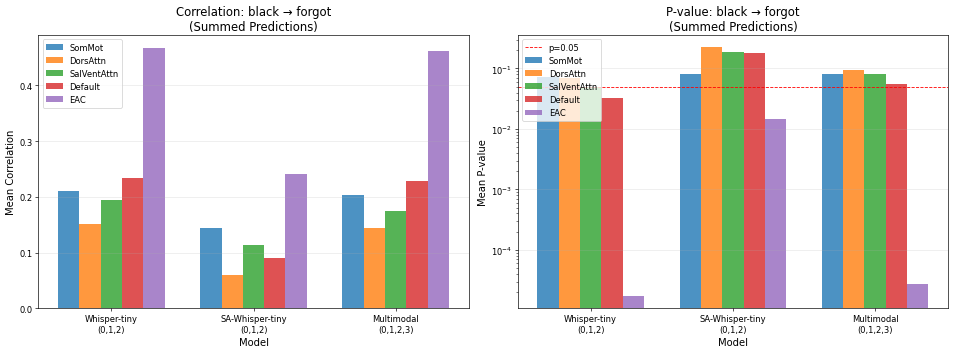

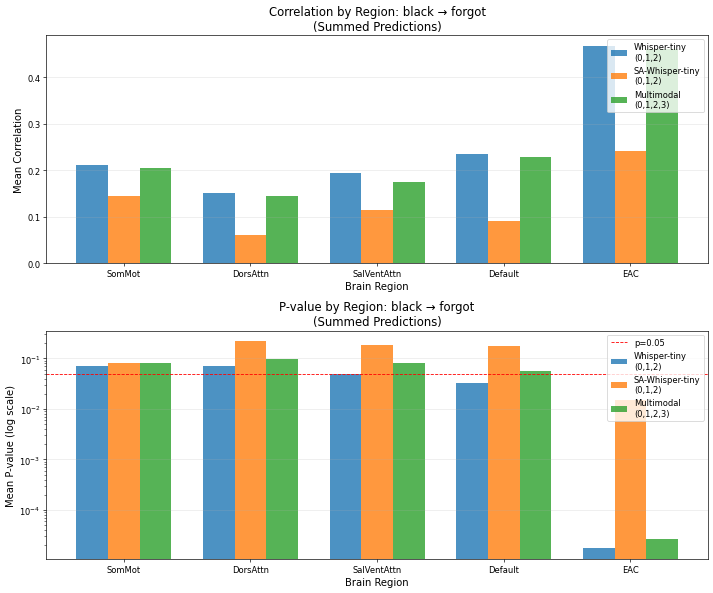

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 各モデルの相関値とp値を収集
models = ['Whisper-tiny\n(0,1,2)', 'SA-Whisper-tiny\n(0,1,2)', 'Multimodal\n(0,1,2,3)']
summed_corr_results = [whisper_tiny_summed_corr, sa_whisper_tiny_summed_corr, multimodal_summed_corr]
summed_pval_results = [whisper_tiny_pvals, sa_whisper_tiny_pvals, multimodal_pvals]

regions = TARGET_NETWORKS + ['EAC']
all_model_corrs = {model: [] for model in models}
all_model_pvals = {model: [] for model in models}

# 各モデルについて領域ごとの値を抽出
for i, model in enumerate(models):
    corr_array = summed_corr_results[i]
    pval_array = summed_pval_results[i]
    
    # Yeoネットワークの値を抽出
    for network in TARGET_NETWORKS:
        corr_val = extract_network_values_from_array(corr_array, atlas, network)
        pval_val = extract_network_values_from_array(pval_array, atlas, network)
        all_model_corrs[model].append(corr_val)
        all_model_pvals[model].append(pval_val)
    
    # EACの値を抽出
    corr_eac = extract_eac_values_from_array(corr_array, atlas, eac_mask_vertex)
    pval_eac = extract_eac_values_from_array(pval_array, atlas, eac_mask_vertex)
    all_model_corrs[model].append(corr_eac)
    all_model_pvals[model].append(pval_eac)

# 棒グラフ作成（2つのサブプロット）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(models))
width = 0.15

# 左側: 相関値
for i, region in enumerate(regions):
    values = [all_model_corrs[model][i] for model in models]
    offset = width * (i - len(regions)/2 + 0.5)
    ax1.bar(x + offset, values, width, label=region, alpha=0.8)

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Mean Correlation', fontsize=12)
ax1.set_title(f'Correlation: {TRAIN_STORY} → {TEST_STORY}\n(Summed Predictions)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# 右側: p値（対数スケール）
for i, region in enumerate(regions):
    values = [all_model_pvals[model][i] for model in models]
    offset = width * (i - len(regions)/2 + 0.5)
    ax2.bar(x + offset, values, width, label=region, alpha=0.8)

ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Mean P-value', fontsize=12)
ax2.set_title(f'P-value: {TRAIN_STORY} → {TEST_STORY}\n(Summed Predictions)', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_yscale('log')  # 対数スケール
ax2.axhline(y=0.05, color='r', linestyle='--', linewidth=1, label='p=0.05')
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig(f'./surface_plot/summed_predictions_{TRAIN_STORY}_to_{TEST_STORY}.png', 
#             dpi=300, bbox_inches='tight')
plt.show()

# 別の可視化: 領域を横軸にした棒グラフ
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

x = np.arange(len(regions))
width = 0.25

# 上側: 相関値
for i, model in enumerate(models):
    values = all_model_corrs[model]
    offset = width * (i - len(models)/2 + 0.5)
    ax1.bar(x + offset, values, width, label=model, alpha=0.8)

ax1.set_xlabel('Brain Region', fontsize=12)
ax1.set_ylabel('Mean Correlation', fontsize=12)
ax1.set_title(f'Correlation by Region: {TRAIN_STORY} → {TEST_STORY}\n(Summed Predictions)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(regions, rotation=0)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# 下側: p値（対数スケール）
for i, model in enumerate(models):
    values = all_model_pvals[model]
    offset = width * (i - len(models)/2 + 0.5)
    ax2.bar(x + offset, values, width, label=model, alpha=0.8)

ax2.set_xlabel('Brain Region', fontsize=12)
ax2.set_ylabel('Mean P-value (log scale)', fontsize=12)
ax2.set_title(f'P-value by Region: {TRAIN_STORY} → {TEST_STORY}\n(Summed Predictions)', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(regions, rotation=0)
ax2.set_yscale('log')
ax2.axhline(y=0.05, color='r', linestyle='--', linewidth=1, label='p=0.05')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig(f'./surface_plot/summed_predictions_by_region_{TRAIN_STORY}_to_{TEST_STORY}.png', 
#             dpi=300, bbox_inches='tight')
plt.show()

In [11]:
import numpy as np
from scipy.stats import pearsonr

def calculate_summed_prediction_correlation(results, train_story, test_story, feature_indices, atlas):
    """
    複数の特徴量によるpredsをsumしてactualとの相関を計算
    
    Parameters:
    -----------
    results : dict
        結果データ
    train_story : str
        訓練ストーリー名
    test_story : str
        テストストーリー名
    feature_indices : list
        sum対象の特徴量インデックスのリスト（例: [0, 1, 2]）
    atlas : object
        アトラス（パーセルデータを頂点データに変換するため）
    
    Returns:
    --------
    correlations : np.ndarray
        各パーセルでの相関係数
    p_values : np.ndarray
        各パーセルでのp値
    """
    key = f'{train_story}->{test_story}'
    
    # actual データを取得
    actual = results[f'{key}_actual']  # shape: (n_samples, n_parcels)
    
    # 指定された特徴量のpredsをsumする
    summed_preds = np.zeros_like(actual)
    for feat_idx in feature_indices:
        preds = results[f'{key}_preds'][feat_idx]  # shape: (n_samples, n_parcels)
        summed_preds += preds
    
    # 各パーセルで相関を計算
    n_parcels = actual.shape[1]
    correlations = np.zeros(n_parcels)
    p_values = np.zeros(n_parcels)
    
    for parcel_idx in range(n_parcels):
        actual_timeseries = actual[:, parcel_idx]
        pred_timeseries = summed_preds[:, parcel_idx]
        
        # NaNを含む場合はスキップ
        if np.any(np.isnan(actual_timeseries)) or np.any(np.isnan(pred_timeseries)):
            correlations[parcel_idx] = np.nan
            p_values[parcel_idx] = np.nan
        else:
            corr, pval = pearsonr(actual_timeseries, pred_timeseries)
            correlations[parcel_idx] = corr
            p_values[parcel_idx] = pval
    
    return correlations, p_values


# 設定
TRAIN_STORY = "black"
TEST_STORIES = ["forgot", "piemanpni", "bronx"]

# 既存の関数を使って領域ごとの値を抽出する場合
def extract_network_values_from_array(corr_array, atlas, network_name):
    """相関配列から指定ネットワークの平均値を抽出"""
    vertex_data = atlas.parc_to_vox(corr_array)
    
    # ネットワークマスク作成
    parcel_labels = atlas.labels
    network_parcel_mask = np.array([1.0 if f'_{network_name}_' in label else 0.0 
                                     for label in parcel_labels])
    network_vertex_mask = atlas.parc_to_vox(network_parcel_mask) > 0
    
    # マスク適用して平均値を計算
    network_values = vertex_data[network_vertex_mask]
    return np.nanmean(network_values)

def extract_eac_values_from_array(corr_array, atlas, eac_mask_vertex):
    """相関配列からEAC領域の平均値を抽出"""
    vertex_data = atlas.parc_to_vox(corr_array)
    eac_values = vertex_data[eac_mask_vertex]
    return np.nanmean(eac_values)

# 各テストストーリーについて計算
TARGET_NETWORKS = ['SomMot', 'DorsAttn', 'SalVentAttn', 'Default']
regions = TARGET_NETWORKS + ['EAC']

# 各モデル・各ストーリーの結果を格納
all_stories_corrs = {
    'Whisper-tiny': [],
    'SA-Whisper-tiny': [],
    'Multimodal': []
}
all_stories_pvals = {
    'Whisper-tiny': [],
    'SA-Whisper-tiny': [],
    'Multimodal': []
}

for test_story in TEST_STORIES:
    print(f"\n{'='*80}")
    print(f"Processing: {TRAIN_STORY} → {test_story}")
    print(f"{'='*80}")
    
    # Whisper-tiny: 特徴量0, 1, 2をsum
    whisper_tiny_features = [0, 1, 2]
    whisper_tiny_summed_corr, whisper_tiny_pvals = calculate_summed_prediction_correlation(
        whisper_tiny_results, TRAIN_STORY, test_story, whisper_tiny_features, atlas
    )
    
    # SA-Whisper-tiny: 特徴量0, 1, 2をsum
    sa_whisper_tiny_features = [0, 1, 2]
    sa_whisper_tiny_summed_corr, sa_whisper_tiny_pvals = calculate_summed_prediction_correlation(
        sa_whisper_tiny_results, TRAIN_STORY, test_story, sa_whisper_tiny_features, atlas
    )
    
    # Multimodal: 特徴量0, 1, 2, 3をsum
    multimodal_features = [0, 1, 2, 3]
    multimodal_summed_corr, multimodal_pvals = calculate_summed_prediction_correlation(
        multimodal_results, TRAIN_STORY, test_story, multimodal_features, atlas
    )
    
    # ストーリーごとの結果を保存
    all_stories_corrs['Whisper-tiny'].append(whisper_tiny_summed_corr)
    all_stories_corrs['SA-Whisper-tiny'].append(sa_whisper_tiny_summed_corr)
    all_stories_corrs['Multimodal'].append(multimodal_summed_corr)
    
    all_stories_pvals['Whisper-tiny'].append(whisper_tiny_pvals)
    all_stories_pvals['SA-Whisper-tiny'].append(sa_whisper_tiny_pvals)
    all_stories_pvals['Multimodal'].append(multimodal_pvals)

# 3つのストーリーの平均を計算
avg_corrs = {
    'Whisper-tiny': np.nanmean(all_stories_corrs['Whisper-tiny'], axis=0),
    'SA-Whisper-tiny': np.nanmean(all_stories_corrs['SA-Whisper-tiny'], axis=0),
    'Multimodal': np.nanmean(all_stories_corrs['Multimodal'], axis=0)
}

avg_pvals = {
    'Whisper-tiny': np.nanmean(all_stories_pvals['Whisper-tiny'], axis=0),
    'SA-Whisper-tiny': np.nanmean(all_stories_pvals['SA-Whisper-tiny'], axis=0),
    'Multimodal': np.nanmean(all_stories_pvals['Multimodal'], axis=0)
}

# 平均結果の表示
print(f"\n{'='*100}")
print(f"AVERAGE ACROSS TEST STORIES: {TRAIN_STORY} → {', '.join(TEST_STORIES)}")
print(f"{'='*100}")

# 全体の平均相関
print("\nOverall Mean Correlations:")
print(f"Whisper-tiny (0,1,2):    {np.nanmean(avg_corrs['Whisper-tiny']):.4f}")
print(f"SA-Whisper-tiny (0,1,2): {np.nanmean(avg_corrs['SA-Whisper-tiny']):.4f}")
print(f"Multimodal (0,1,2,3):    {np.nanmean(avg_corrs['Multimodal']):.4f}")

# 領域ごとの平均相関値
print("\n" + "="*100)
print("Mean Correlations by Region:")
print("-"*100)
print(f"{'Region':15s} | {'Whisper-tiny':15s} | {'SA-Whisper-tiny':15s} | {'Multimodal':15s}")
print(f"{'':15s} | {'(0,1,2)':15s} | {'(0,1,2)':15s} | {'(0,1,2,3)':15s}")
print("-"*100)

for network in TARGET_NETWORKS:
    whisper_val = extract_network_values_from_array(avg_corrs['Whisper-tiny'], atlas, network)
    sa_whisper_val = extract_network_values_from_array(avg_corrs['SA-Whisper-tiny'], atlas, network)
    multimodal_val = extract_network_values_from_array(avg_corrs['Multimodal'], atlas, network)
    print(f"{network:15s} | {whisper_val:15.4f} | {sa_whisper_val:15.4f} | {multimodal_val:15.4f}")

# EAC
whisper_eac = extract_eac_values_from_array(avg_corrs['Whisper-tiny'], atlas, eac_mask_vertex)
sa_whisper_eac = extract_eac_values_from_array(avg_corrs['SA-Whisper-tiny'], atlas, eac_mask_vertex)
multimodal_eac = extract_eac_values_from_array(avg_corrs['Multimodal'], atlas, eac_mask_vertex)
print(f"{'EAC':15s} | {whisper_eac:15.4f} | {sa_whisper_eac:15.4f} | {multimodal_eac:15.4f}")

# p値の表示
print("\n" + "="*100)
print("Mean P-values by Region:")
print("-"*100)
print(f"{'Region':15s} | {'Whisper-tiny':15s} | {'SA-Whisper-tiny':15s} | {'Multimodal':15s}")
print("-"*100)

for network in TARGET_NETWORKS:
    whisper_pval = extract_network_values_from_array(avg_pvals['Whisper-tiny'], atlas, network)
    sa_whisper_pval = extract_network_values_from_array(avg_pvals['SA-Whisper-tiny'], atlas, network)
    multimodal_pval = extract_network_values_from_array(avg_pvals['Multimodal'], atlas, network)
    print(f"{network:15s} | {whisper_pval:15.6f} | {sa_whisper_pval:15.6f} | {multimodal_pval:15.6f}")

# EAC
whisper_eac_pval = extract_eac_values_from_array(avg_pvals['Whisper-tiny'], atlas, eac_mask_vertex)
sa_whisper_eac_pval = extract_eac_values_from_array(avg_pvals['SA-Whisper-tiny'], atlas, eac_mask_vertex)
multimodal_eac_pval = extract_eac_values_from_array(avg_pvals['Multimodal'], atlas, eac_mask_vertex)
print(f"{'EAC':15s} | {whisper_eac_pval:15.6f} | {sa_whisper_eac_pval:15.6f} | {multimodal_eac_pval:15.6f}")

# 可視化用のデータを準備
models = ['Whisper-tiny\n(0,1,2)', 'SA-Whisper-tiny\n(0,1,2)', 'Multimodal\n(0,1,2,3)']
all_model_corrs = {
    models[0]: [],
    models[1]: [],
    models[2]: []
}
all_model_pvals = {
    models[0]: [],
    models[1]: [],
    models[2]: []
}

# 各領域の値を抽出
for network in TARGET_NETWORKS:
    whisper_val = extract_network_values_from_array(avg_corrs['Whisper-tiny'], atlas, network)
    sa_whisper_val = extract_network_values_from_array(avg_corrs['SA-Whisper-tiny'], atlas, network)
    multimodal_val = extract_network_values_from_array(avg_corrs['Multimodal'], atlas, network)
    
    all_model_corrs[models[0]].append(whisper_val)
    all_model_corrs[models[1]].append(sa_whisper_val)
    all_model_corrs[models[2]].append(multimodal_val)
    
    whisper_pval = extract_network_values_from_array(avg_pvals['Whisper-tiny'], atlas, network)
    sa_whisper_pval = extract_network_values_from_array(avg_pvals['SA-Whisper-tiny'], atlas, network)
    multimodal_pval = extract_network_values_from_array(avg_pvals['Multimodal'], atlas, network)
    
    all_model_pvals[models[0]].append(whisper_pval)
    all_model_pvals[models[1]].append(sa_whisper_pval)
    all_model_pvals[models[2]].append(multimodal_pval)

# EAC
all_model_corrs[models[0]].append(whisper_eac)
all_model_corrs[models[1]].append(sa_whisper_eac)
all_model_corrs[models[2]].append(multimodal_eac)

all_model_pvals[models[0]].append(whisper_eac_pval)
all_model_pvals[models[1]].append(sa_whisper_eac_pval)
all_model_pvals[models[2]].append(multimodal_eac_pval)


Processing: black → forgot

Processing: black → piemanpni

Processing: black → bronx

AVERAGE ACROSS TEST STORIES: black → forgot, piemanpni, bronx

Overall Mean Correlations:
Whisper-tiny (0,1,2):    0.0667
SA-Whisper-tiny (0,1,2): 0.0338
Multimodal (0,1,2,3):    0.0587

Mean Correlations by Region:
----------------------------------------------------------------------------------------------------
Region          | Whisper-tiny    | SA-Whisper-tiny | Multimodal     
                | (0,1,2)         | (0,1,2)         | (0,1,2,3)      
----------------------------------------------------------------------------------------------------
SomMot          |          0.0808 |          0.0422 |          0.0715
DorsAttn        |          0.0940 |          0.0863 |          0.0816
SalVentAttn     |          0.0660 |          0.0304 |          0.0598
Default         |          0.0689 |          0.0335 |          0.0665
EAC             |          0.0051 |         -0.1265 |         -0.0028

Mean

/tmp/ipykernel_720194/3792988689.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='upper left')


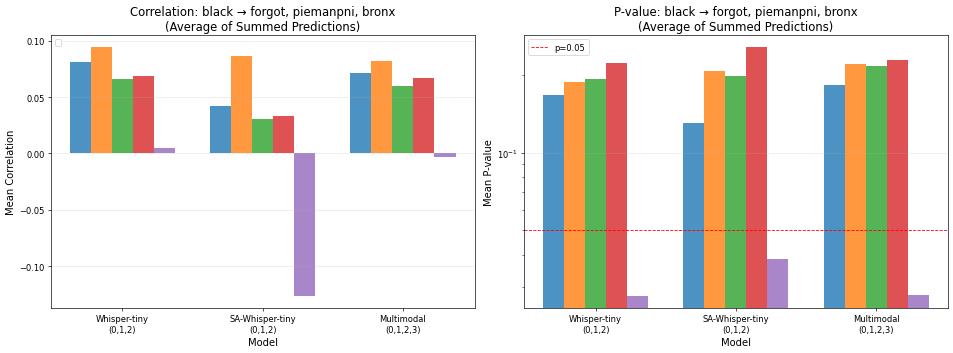

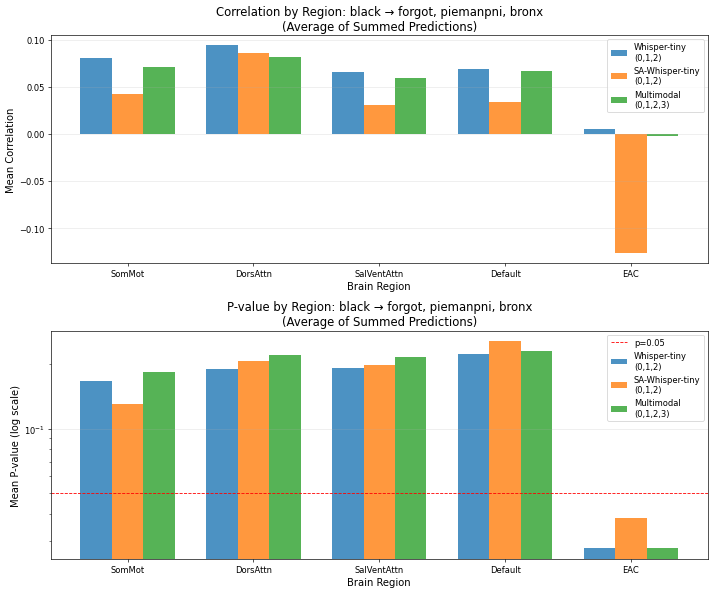

In [14]:
import matplotlib.pyplot as plt

# 棒グラフ作成（2つのサブプロット）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(models))
width = 0.15

# 左側: 相関値
for i, region in enumerate(regions):
    values = [all_model_corrs[model][i] for model in models]
    offset = width * (i - len(regions)/2 + 0.5)
    ax1.bar(x + offset, values, width, alpha=0.8)

ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Mean Correlation', fontsize=12)
ax1.set_title(f'Correlation: {TRAIN_STORY} → {", ".join(TEST_STORIES)}\n(Average of Summed Predictions)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# 右側: p値（対数スケール）
for i, region in enumerate(regions):
    values = [all_model_pvals[model][i] for model in models]
    offset = width * (i - len(regions)/2 + 0.5)
    ax2.bar(x + offset, values, width, alpha=0.8)

ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Mean P-value', fontsize=12)
ax2.set_title(f'P-value: {TRAIN_STORY} → {", ".join(TEST_STORIES)}\n(Average of Summed Predictions)', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.set_yscale('log')
ax2.axhline(y=0.05, color='r', linestyle='--', linewidth=1, label='p=0.05')
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig(f'./surface_plot/summed_predictions_{TRAIN_STORY}_avg_across_stories.png', 
#             dpi=300, bbox_inches='tight')
plt.show()

# 別の可視化: 領域を横軸にした棒グラフ
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

x = np.arange(len(regions))
width = 0.25

# 上側: 相関値
for i, model in enumerate(models):
    values = all_model_corrs[model]
    offset = width * (i - len(models)/2 + 0.5)
    ax1.bar(x + offset, values, width, label=model, alpha=0.8)

ax1.set_xlabel('Brain Region', fontsize=12)
ax1.set_ylabel('Mean Correlation', fontsize=12)
ax1.set_title(f'Correlation by Region: {TRAIN_STORY} → {", ".join(TEST_STORIES)}\n(Average of Summed Predictions)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(regions, rotation=0)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# 下側: p値（対数スケール）
for i, model in enumerate(models):
    values = all_model_pvals[model]
    offset = width * (i - len(models)/2 + 0.5)
    ax2.bar(x + offset, values, width, label=model, alpha=0.8)

ax2.set_xlabel('Brain Region', fontsize=12)
ax2.set_ylabel('Mean P-value (log scale)', fontsize=12)
ax2.set_title(f'P-value by Region: {TRAIN_STORY} → {", ".join(TEST_STORIES)}\n(Average of Summed Predictions)', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(regions, rotation=0)
ax2.set_yscale('log')
ax2.axhline(y=0.05, color='r', linestyle='--', linewidth=1, label='p=0.05')
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig(f'./surface_plot/summed_predictions_by_region_{TRAIN_STORY}_avg_across_stories.png', 
#             dpi=300, bbox_inches='tight')
plt.show()

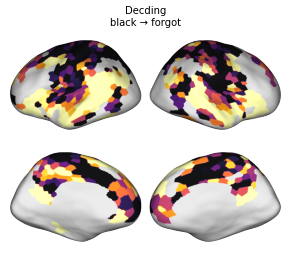

In [16]:
# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "forgot"
FEATURE_IDX = 2  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Decding"

values = whisper_tiny_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan

fig, ax = plt.subplots(figsize=(6, 5))
plot.surface_plot(atlas.parc_to_vox(values), cmap='inferno', vmin=0.05, vmax=0.2, 
                  title=f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fig=fig, ax=ax, cbar=False)
# fig.savefig(f'./surface_plot/sa_whisper_tiny_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}.png', dpi=150, bbox_inches='tight')
plt.show()

2025-12-13 17:52:04.996 (15323.939s) [    7F6DE7904740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
/tmp/ipykernel_775519/686413127.py:79: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [mpatches.Patch(color=info['color'], label=name, linewidth=2, edgecolor='white')
/tmp/ipykernel_775519/686413127.py:81: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches.append(mpatches.Patch(color=EAC_COLOR, label='EAC', linewidth=2, edgecolor='white'))


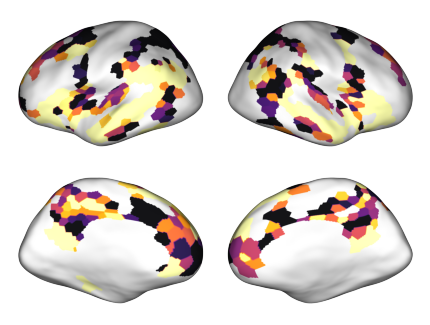

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from neuromaps import datasets, images
from neuromaps.datasets import fetch_fsaverage
import numpy as np
from os.path import join

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORY = "forgot"
FEATURE_IDX = 2  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "Language"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#00BFFF'},      # より明るい青（DeepSkyBlue）
    'DorsAttn': {'color': '#00FF00'},    # ライムグリーン
    'SalVentAttn': {'color': '#FF00FF'}, # マゼンタ
    'Default': {'color': '#ff0000'}
}

# EAC設定を追加
EAC_COLOR = "#ffff00"  # 黄色（または他の目立つ色）

# EACデータの読み込み
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_vertex_data = np.concatenate((eac_lh_data, eac_rh_data))

# データ準備（network_maskのみ使用）
values = whisper_tiny_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# EAC領域のvertex_dataをマスク解除（元のvaluesから取得）
values_full = whisper_tiny_results[f'{TRAIN_STORY}->{TEST_STORY}_scores'][FEATURE_IDX].copy()
vertex_data_full = atlas.parc_to_vox(values_full)

# EAC領域でvertex_dataを上書き
vertex_data[eac_vertex_data > 0] = vertex_data_full[eac_vertex_data > 0]

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
p.add_layer(vertex_data, cmap='inferno', cbar=False, color_range=[0.05, 0.2])

# # 各ネットワークのアウトラインを追加
# parcel_labels = atlas.labels

# for net_name, info in TARGET_NETWORKS_INFO.items():
#     # parcel単位でネットワークマスクを作成
#     network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
#                                      for label in parcel_labels])
    
#     network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
#     p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
#                 as_outline=True, cbar=False)

# # EACのアウトラインを追加
# p.add_layer(eac_vertex_data, cmap=ListedColormap([EAC_COLOR]), 
#             as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# 凡例追加（EACを含む）
legend_patches = [mpatches.Patch(color=info['color'], label=name, linewidth=2, edgecolor='white') 
                  for name, info in TARGET_NETWORKS_INFO.items()]
legend_patches.append(mpatches.Patch(color=EAC_COLOR, label='EAC', linewidth=2, edgecolor='white'))

# fig.legend(handles=legend_patches, loc='lower right', fontsize=11, 
#            frameon=True, fancybox=True, shadow=True, edgecolor='black')

# fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {TEST_STORY}', fontsize=14, fontweight='bold')
fig.savefig(f'./surface_plot/whisper_tiny_{TRAIN_STORY}_to_{TEST_STORY}_{FEATURE_NAME}_nonoutline.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

/tmp/ipykernel_720194/1758703770.py:85: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [mpatches.Patch(color=info['color'], label=name, linewidth=2, edgecolor='white')
/tmp/ipykernel_720194/1758703770.py:87: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches.append(mpatches.Patch(color=EAC_COLOR, label='EAC', linewidth=2, edgecolor='white'))


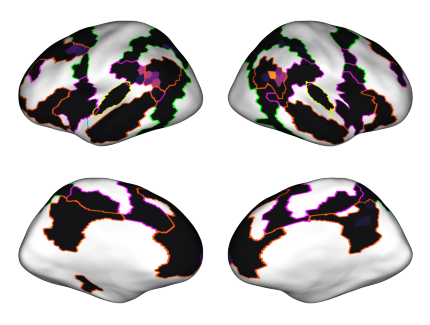

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from neuromaps import datasets, images
from neuromaps.datasets import fetch_fsaverage
import numpy as np
from os.path import join

# 単一のfeatureと組み合わせを指定
TRAIN_STORY = "black"
TEST_STORIES = ["forgot", "piemanpni", "bronx"]  # 3つのテストストーリー
FEATURE_IDX = 3  # 0=Acoustic, 1=Encoding, 2=Decoding
FEATURE_NAME = "SBERT"

# ネットワーク定義とアウトライン色
TARGET_NETWORKS_INFO = {
    'SomMot': {'color': '#00BFFF'},      # より明るい青（DeepSkyBlue）
    'DorsAttn': {'color': '#00FF00'},    # ライムグリーン
    'SalVentAttn': {'color': '#FF00FF'}, # マゼンタ
    'Default': {'color': '#FF4500'}      # オレンジレッド
}

# EAC設定を追加
EAC_COLOR = '#FFFF00'  # 黄色（または他の目立つ色）

# EACデータの読み込み
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_vertex_data = np.concatenate((eac_lh_data, eac_rh_data))

# 3つのテストストーリーのスコアを平均
scores_list = []
for test_story in TEST_STORIES:
    scores = multimodal_results[f'{TRAIN_STORY}->{test_story}_scores'][FEATURE_IDX].copy()
    scores_list.append(scores)

# 平均を計算
values = np.mean(scores_list, axis=0)
values[~network_mask] = np.nan
vertex_data = atlas.parc_to_vox(values)

# EAC領域のvertex_dataをマスク解除（元のvaluesから取得）
values_full = np.mean(scores_list, axis=0)
vertex_data_full = atlas.parc_to_vox(values_full)

# EAC領域でvertex_dataを上書き
vertex_data[eac_vertex_data > 0] = vertex_data_full[eac_vertex_data > 0]

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

# Plotオブジェクト作成
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# メインデータレイヤー
p.add_layer(vertex_data, cmap='inferno', cbar=False, color_range=[0.05, 0.2])

# # 各ネットワークのアウトラインを追加
# parcel_labels = atlas.labels

# for net_name, info in TARGET_NETWORKS_INFO.items():
#     # parcel単位でネットワークマスクを作成
#     network_parcel_mask = np.array([1.0 if f'_{net_name}_' in label else 0.0 
#                                      for label in parcel_labels])
    
#     network_vertex = atlas.parc_to_vox(network_parcel_mask)
    
#     p.add_layer(network_vertex, cmap=ListedColormap([info['color']]), 
#                 as_outline=True, cbar=False)

# # EACのアウトラインを追加
# p.add_layer(eac_vertex_data, cmap=ListedColormap([EAC_COLOR]), 
#             as_outline=True, cbar=False)

cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=12)
fig = p.build(cbar_kws=cbar_kws)

# 凡例追加（EACを含む）
legend_patches = [mpatches.Patch(color=info['color'], label=name, linewidth=2, edgecolor='white') 
                  for name, info in TARGET_NETWORKS_INFO.items()]
legend_patches.append(mpatches.Patch(color=EAC_COLOR, label='EAC', linewidth=2, edgecolor='white'))

# fig.legend(handles=legend_patches, loc='lower right', fontsize=11, 
#            frameon=True, fancybox=True, shadow=True, edgecolor='black')

# # タイトルとファイル名を複数ストーリー用に修正
test_stories_str = '+'.join(TEST_STORIES)
# fig.suptitle(f'{FEATURE_NAME}\n{TRAIN_STORY} → {test_stories_str}', fontsize=14, fontweight='bold')
fig.savefig(f'./surface_plot/multimodal_{TRAIN_STORY}_to_{test_stories_str}_{FEATURE_NAME}_with_EAC.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

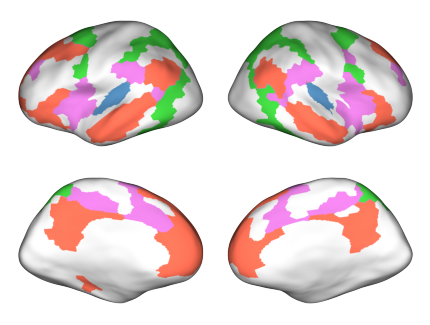

<Figure size 180x180 with 0 Axes>

In [111]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from neuromaps import images
from os.path import join

# ネットワーク定義と色（display_name追加）
TARGET_NETWORKS_INFO = {
    'DorsAttn': {'color': '#32CD32', 'id': 2, 'display_name': 'Dorsal Attention'},
    'SalVentAttn': {'color': '#DA70D6', 'id': 3, 'display_name': 'Ventral Attention'},
    'Default': {'color': '#FF6347', 'id': 4, 'display_name': 'Default Mode'}
}

# EAC設定を追加
EAC_INFO = {'color': '#4682B4', 'id': 5, 'display_name': 'EAC'}

# EACデータの読み込み
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_vertex_data = np.concatenate((eac_lh_data, eac_rh_data))

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

parcel_labels = atlas.labels

# === 全ネットワーク＋EACをまとめて表示 ===
p = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# ネットワークIDをパーセル空間で作成
network_ids = np.zeros(len(parcel_labels))
for net_name, info in TARGET_NETWORKS_INFO.items():
    for i, label in enumerate(parcel_labels):
        if f'_{net_name}_' in label:
            network_ids[i] = info['id']

# 頂点空間に変換
network_vertex = atlas.parc_to_vox(network_ids)

# EACを頂点空間で直接追加（優先度を上げるため後から上書き）
network_vertex[eac_vertex_data > 0] = EAC_INFO['id']

# カラーマップ作成（0=背景, 1=未使用, 2=DorsAttn, 3=SalVentAttn, 4=Default, 5=EAC）
colors = ['#dddddd', '#1f77b4', '#32CD32', '#DA70D6', '#FF6347', '#4682B4']
cmap = ListedColormap(colors)

p.add_layer(network_vertex, cmap=cmap, cbar=False, color_range=[0, 5])
fig = p.build()

fig.savefig('./surface_plot/target_networks.png', dpi=300, bbox_inches='tight')
plt.show()

# === 凡例だけを別ファイルで保存（EAC追加） ===
fig_legend = plt.figure(figsize=(3, 3))
legend_patches = [mpatches.Patch(color=info['color'], label=info['display_name']) 
                  for name, info in TARGET_NETWORKS_INFO.items()]
# EACを追加
legend_patches.append(mpatches.Patch(color=EAC_INFO['color'], label=EAC_INFO['display_name']))

legend = fig_legend.legend(handles=legend_patches, loc='center', fontsize=12, 
                          frameon=False, fancybox=False, shadow=False)
fig_legend.tight_layout()
fig_legend.savefig('./surface_plot/networks_legend.png', dpi=300, bbox_inches='tight')
plt.show()

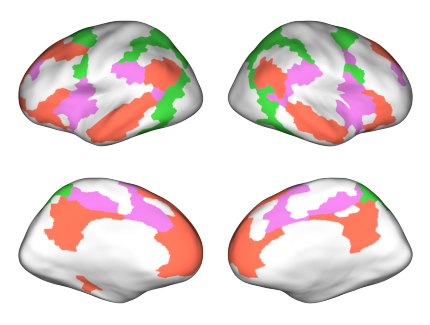

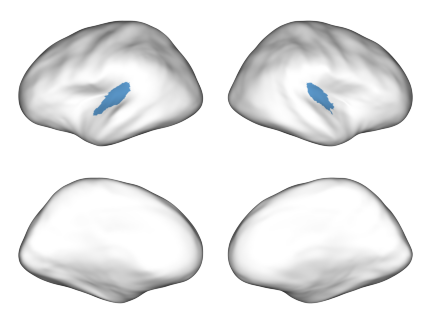

<Figure size 180x120 with 0 Axes>

<Figure size 120x60 with 0 Axes>

In [110]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from neuromaps import images
from os.path import join

# ネットワーク定義と色（display_name追加）
TARGET_NETWORKS_INFO = {
    'DorsAttn': {'color': '#32CD32', 'id': 2, 'display_name': 'Dorsal Attention'},
    'SalVentAttn': {'color': '#DA70D6', 'id': 3, 'display_name': 'Ventral Attention'},
    'Default': {'color': '#FF6347', 'id': 4, 'display_name': 'Default Mode'}
}

# EAC設定を追加
EAC_INFO = {'color': '#4682B4', 'id': 5, 'display_name': 'EAC'}

# EACデータの読み込み
base_dir = '/disk1/MRI-Data_in-use/20_narrativefMRI/10_ds002245-v.1.0.3_Hasson/'
afni_dir = join(base_dir, 'derivatives', 'afni-nosmooth')
tpl_dir = join(afni_dir, 'tpl-fsaverage6')

eac_lh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-L_desc-EAC_mask.label.gii")
eac_rh = images.load_gifti(tpl_dir + "/tpl-fsaverage6_hemi-R_desc-EAC_mask.label.gii")
eac_lh_data = eac_lh.agg_data()
eac_rh_data = eac_rh.agg_data()
eac_vertex_data = np.concatenate((eac_lh_data, eac_rh_data))

# Surfaceを取得
surfaces = plot.fetch_fsaverage()
lh, rh = surfaces['inflated']

parcel_labels = atlas.labels

# === ネットワークのみ表示 ===
p_networks = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# ネットワークIDをパーセル空間で作成
network_ids = np.zeros(len(parcel_labels))
for net_name, info in TARGET_NETWORKS_INFO.items():
    for i, label in enumerate(parcel_labels):
        if f'_{net_name}_' in label:
            network_ids[i] = info['id']

# 頂点空間に変換
network_vertex = atlas.parc_to_vox(network_ids)

# カラーマップ作成（0=背景, 1=未使用, 2=DorsAttn, 3=SalVentAttn, 4=Default）
colors_networks = ['#dddddd', '#1f77b4', '#32CD32', '#DA70D6', '#FF6347']
cmap_networks = ListedColormap(colors_networks)

p_networks.add_layer(network_vertex, cmap=cmap_networks, cbar=False, color_range=[0, 4])
fig_networks = p_networks.build()

fig_networks.savefig('./surface_plot/target_networks_only.png', dpi=300, bbox_inches='tight')
plt.show()

# === EACのみ表示 ===
p_eac = plot.Plot(lh, rh, size=(800, 600), brightness=.8)

# EACデータ（0=背景, 1=EAC）
eac_display = eac_vertex_data.copy()

# カラーマップ作成（0=背景, 1=EAC）
colors_eac = ['#dddddd', '#4682B4']
cmap_eac = ListedColormap(colors_eac)

p_eac.add_layer(eac_display, cmap=cmap_eac, cbar=False, color_range=[0, 1])
fig_eac = p_eac.build()

fig_eac.savefig('./surface_plot/EAC_only.png', dpi=300, bbox_inches='tight')
plt.show()

# === ネットワークの凡例 ===
fig_legend_networks = plt.figure(figsize=(3, 2))
legend_patches_networks = [mpatches.Patch(color=info['color'], label=info['display_name']) 
                           for name, info in TARGET_NETWORKS_INFO.items()]

legend_networks = fig_legend_networks.legend(handles=legend_patches_networks, loc='center', fontsize=12, 
                                             frameon=False, fancybox=False, shadow=False)
fig_legend_networks.tight_layout()
fig_legend_networks.savefig('./surface_plot/networks_legend.png', dpi=300, bbox_inches='tight')
plt.show()

# === EACの凡例 ===
fig_legend_eac = plt.figure(figsize=(2, 1))
legend_patches_eac = [mpatches.Patch(color=EAC_INFO['color'], label=EAC_INFO['display_name'])]

legend_eac = fig_legend_eac.legend(handles=legend_patches_eac, loc='center', fontsize=12, 
                                   frameon=False, fancybox=False, shadow=False)
fig_legend_eac.tight_layout()
fig_legend_eac.savefig('./surface_plot/EAC_legend.png', dpi=300, bbox_inches='tight')
plt.show()